<h1 style="color: #492c68;">01 | PREPROCESSING</h1>

<h2 style="color: #327a81;">Libraries</h2>

In [1]:
## Basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import chardet

## Settings

pd.set_option('display.max_columns', None) # display all columns
import warnings
warnings.filterwarnings('ignore') # ignore warnings

<h2 style="color: #327a81;">Data Standardization</h2>

In [2]:
with open("26014.csv", "rb") as f:
    result = chardet.detect(f.read())
    encode = result["encoding"]

In [3]:
data = pd.read_csv("26014.csv", encoding=encode, sep="\t")

In [4]:
data

,Tipo de Delito: Nivel 1,Tipo de Delito: Nivel 2,Tipo de Delito: Nivel 3,Tipo de Delito: Nivel 4,Nacionalidad,Periodo,Total
0,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2022,800.0
1,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2021,876.0
2,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2020,786.0
3,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2019,847.0
4,A Delitos,1 Homicidio y sus formas,NaN,NaN,Española,2018,837.0
...,...,...,...,...,...,...,...
625,A Delitos,22 Contra el orden público,NaN,NaN,De Oceanía,2017,2.0
626,A Delitos,22 Contra el orden público,NaN,NaN,De Oceanía,2016,4.0
627,A Delitos,22 Contra el orden público,NaN,NaN,De Oceanía,2015,1.0
628,A Delitos,22 Contra el orden público,NaN,NaN,De Oceanía,2014,7.0


In [5]:
df = data.copy()

In [6]:
# Changing all columns names to lowercase for better usability

df.columns = map(str.lower, df.columns)

<h3 style="color: #60b671;">Dataset shape & types</h3>

In [7]:
df.shape

(630, 7)

In [8]:
df.dtypes

tipo de delito: nivel 1     object
tipo de delito: nivel 2     object
tipo de delito: nivel 3     object
tipo de delito: nivel 4    float64
nacionalidad                object
periodo                      int64
total                      float64
dtype: object

<h3 style="color: #60b671;">Dealing with numerical types: floats bigger than 1K in "total"</h3>

- "total" field is recognised as float. It has interpreted x>1000 values as decimals instead of thounsads. We need to fix it

In [9]:
# Create a function that fixes thousands instead of decimals

def total_fixer(value):
    if pd.notna(value) and value != int(value):
        return value * 1000
    return value

In [10]:
df["total"] = df["total"].apply(total_fixer)

In [11]:
# Turn "total" type into integer, so it will be leaner. For that we need to deal with total nulls
#After dealing with nulls, let's convert all to int

df["total"] = df["total"].fillna(0)
df["total"] = df["total"].astype(int)

In [12]:
df["total"].head(10)

0     800
1     876
2     786
3     847
4     837
5     925
6    1028
7    1071
8    1012
9    1096
Name: total, dtype: int32

<h3 style="color: #60b671;">Dealing with nulls</h3>

In [13]:
df.isnull().sum()

tipo de delito: nivel 1      0
tipo de delito: nivel 2      0
tipo de delito: nivel 3    360
tipo de delito: nivel 4    630
nacionalidad                 0
periodo                      0
total                        0
dtype: int64

- crime type fields causes the nulls because of the specific sublevels, so we will make a new column to have only one variable for the type of crime

In [14]:
crimes = df.iloc[:, [0, 1, 2, 3]]

In [15]:
crimes.head(1)

,tipo de delito: nivel 1,tipo de delito: nivel 2,tipo de delito: nivel 3,tipo de delito: nivel 4
0,A Delitos,1 Homicidio y sus formas,NaN,NaN


In [16]:
# column 0 is irrelevant, so we drop it

crimes = crimes.drop(columns="tipo de delito: nivel 1")

In [17]:
# It will be better if we rename the crime levels for a better usability

crimes = crimes.rename(columns={"tipo de delito: nivel 2":"n_2",
                      "tipo de delito: nivel 3": "n_3", "tipo de delito: nivel 4":"n_4"})

In [18]:
# Use iterrows to fill the new list, this will be the new column without nulls

tipo_delito = []

for index, row in crimes.iterrows():
    if pd.notna(row["n_3"]):
        tipo_delito.append(row["n_3"])
    elif pd. notna(row["n_4"]):
        tipo_delito.append(row["n_4"])
    else:
        tipo_delito.append(row["n_2"])

In [19]:
# Erase the epigraph number to clean the values with a list comprehension

tipo_delito = [string.split(" ", 1)[1] for string in tipo_delito]

In [20]:
df.drop(columns=df.columns[[0, 1, 2, 3]], inplace=True)

In [21]:
df.insert(0, "tipo_delito", tipo_delito)

In [22]:
# After dealing with crime types, Let's check again for nulls

df.isnull().sum()

tipo_delito     0
nacionalidad    0
periodo         0
total           0
dtype: int64

In [23]:
# And check how crimes look at the end

df["tipo_delito"].value_counts()

tipo_delito
Homicidio y sus formas           90
Lesiones                         90
Hurtos                           90
Robos                            90
Daños                            90
Contra la seguridad colectiva    90
Contra el orden público          90
Name: count, dtype: int64

<h3 style="color: #60b671;">Extra wrangling: simplifying confusing fields</h3>

In [24]:
# Europe area could be difficult to understand because of its segmentation, so it will be better if we reunite all in one

df["nacionalidad"].value_counts()

nacionalidad
Española                           70
País de la UE28 sin España         70
País de la UE27_2020 sin España    70
País de Europa menos UE28          70
País de Europa menos UE27_2020     70
De Africa                          70
De América                         70
De Asia                            70
De Oceanía                         70
Name: count, dtype: int64

In [25]:
# Use a mapping to rename all Europe divisions in only one

mapping = {
    "País de la UE28 sin España": "De Europa",
    "País de la UE27_2020 sin España": "De Europa",
    "País de Europa menos UE28": "De Europa",
    "País de Europa menos UE27_2020": "De Europa"
}

In [26]:
df["nacionalidad"] = df["nacionalidad"].replace(mapping)

In [27]:
# And finally, group up those variables to sum their values

columns_group = df.groupby(["tipo_delito", "nacionalidad", "periodo"])
df = columns_group["total"].sum().reset_index()

In [28]:
# Check once more "nacionalidad" to see how it end

df["nacionalidad"].value_counts()

nacionalidad
De Africa     70
De América    70
De Asia       70
De Europa     70
De Oceanía    70
Española      70
Name: count, dtype: int64

<h3 style="color: #60b671;">Clearing the dataset: dropping "De Oceanía"</h3>

- Nacionality "De Oceanía" has too low numbers that doensn't affect in statistics, so it will be better if we drop this rows from the dataset

In [29]:
df = df[df["nacionalidad"] != "De Oceanía"]

<h3 style="color: #60b671;">Dataframe final glance</h3>

In [30]:
print(df.sample(20))

                       tipo_delito nacionalidad  periodo  total
159                          Daños    De Europa     2022    711
336                       Lesiones    De Europa     2019   5523
137                          Daños   De América     2020    406
395                          Robos    De Europa     2018   2463
138                          Daños   De América     2021    582
154                          Daños    De Europa     2017    741
410                          Robos     Española     2013  22855
136                          Daños   De América     2019    502
257                         Hurtos   De América     2020   4684
396                          Robos    De Europa     2019   2287
255                         Hurtos   De América     2018   5131
97   Contra la seguridad colectiva    De Europa     2020   6405
150                          Daños    De Europa     2013    280
31         Contra el orden público    De Europa     2014   1250
306                       Lesiones    De

<h1 style="color: #492c68;">02 | EDA</h1>

<h2 style="color: #327a81;">Crime types analysis</h2>

- First at all, we define a function that helps us to filter our df by crime type

In [31]:
def crime_type_filter(value):
    df_delito = df[df["tipo_delito"] == value]
    return df_delito    

In [32]:
# Now we can segment the data in crime type variables

orden_publico = crime_type_filter("Contra el orden público")
seguridad_colectiva = crime_type_filter("Contra la seguridad colectiva")
daños = crime_type_filter("Daños")
homicidios = crime_type_filter("Homicidio y sus formas")
hurtos = crime_type_filter("Hurtos")
lesiones = crime_type_filter("Lesiones")
robos = crime_type_filter("Robos")

<h2 style="color: #327a81;">Type: Against Public Order</h2>

<h3 style="color: #60b671;">Decade Numbers and Percetage</h3>

In [33]:
orden_publico_general = orden_publico.groupby("nacionalidad")["total"].sum().sort_values(ascending=False).reset_index()

In [34]:
orden_publico_general

,nacionalidad,total
0,Española,103221
1,De Africa,15294
2,De Europa,14700
3,De América,12485
4,De Asia,941


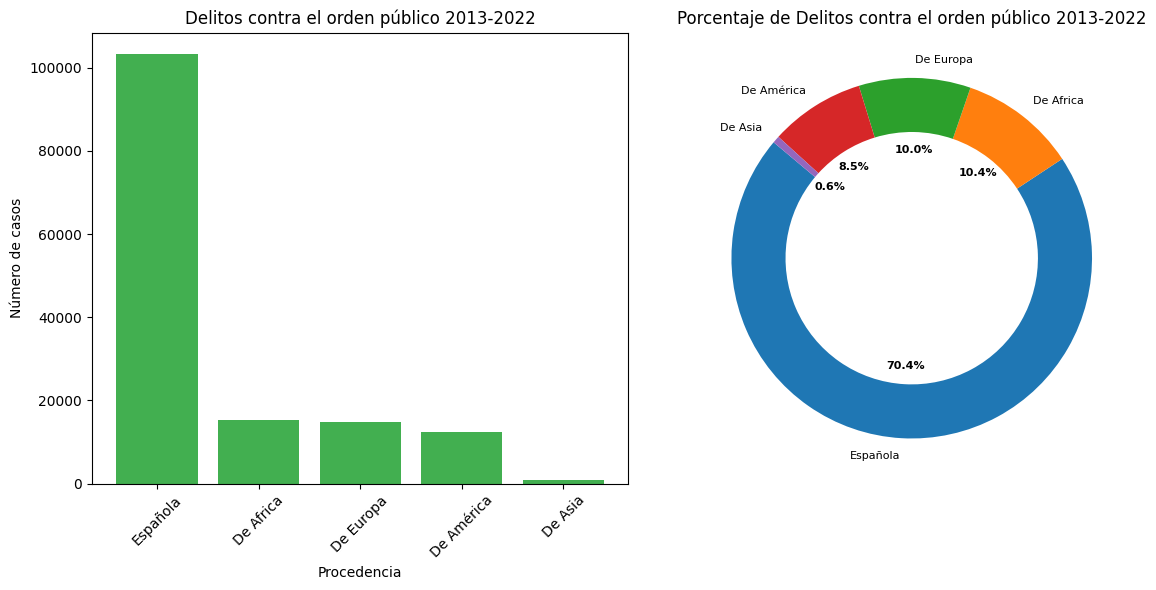

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(orden_publico_general["nacionalidad"], orden_publico_general["total"], color="#42af50")
axes[0].set_xlabel("Procedencia")
axes[0].set_ylabel("Número de casos")
axes[0].set_title("Delitos contra el orden público 2013-2022")
axes[0].tick_params(axis='x', rotation=45)

orden_publico_general["porcentaje"] = round(orden_publico_general["total"] / orden_publico_general["total"].sum() * 100, 2)

wedges, texts, autotexts = axes[1].pie(orden_publico_general["porcentaje"], labels=orden_publico_general["nacionalidad"], 
                                       autopct="%1.1f%%", startangle=140, wedgeprops=dict(width=0.3))
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)
axes[1].set_title("Porcentaje de Delitos contra el orden público 2013-2022")

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Evolution in the last 10 years</h3>

In [36]:
orden_publico.head(1)

,tipo_delito,nacionalidad,periodo,total
0,Contra el orden público,De Africa,2013,1218


In [37]:
orden_publico["nacionalidad"].unique()

array(['De Africa', 'De América', 'De Asia', 'De Europa', 'Española'],
      dtype=object)

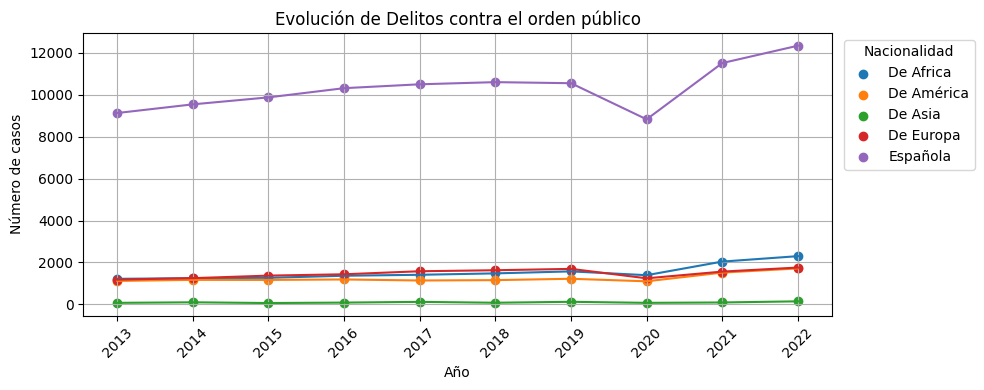

In [38]:
plt.figure(figsize=(10,4))
nacionalidades = orden_publico["nacionalidad"].unique()

for i, nacionalidad in enumerate(nacionalidades):
    subset = orden_publico[orden_publico["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["total"], label= nacionalidad)
    plt.plot(subset["periodo"], subset["total"])
    
plt.xticks(range(2013,2023), rotation= 45)
    
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.title("Evolución de Delitos contra el orden público")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Percentage of crime growth by year</h3>

In [39]:
orden_publico["porcentaje_crecimiento"] = round(orden_publico.groupby("nacionalidad")["total"].pct_change()*100,2)
orden_publico["porcentaje_crecimiento"].fillna(0, inplace=True)

In [40]:
# Calculate the average percentage growth by origin in the last decade

orden_publico.groupby("nacionalidad")["porcentaje_crecimiento"].mean()

nacionalidad
De Africa      7.408
De América     5.014
De Asia       14.257
De Europa      4.898
Española       3.602
Name: porcentaje_crecimiento, dtype: float64

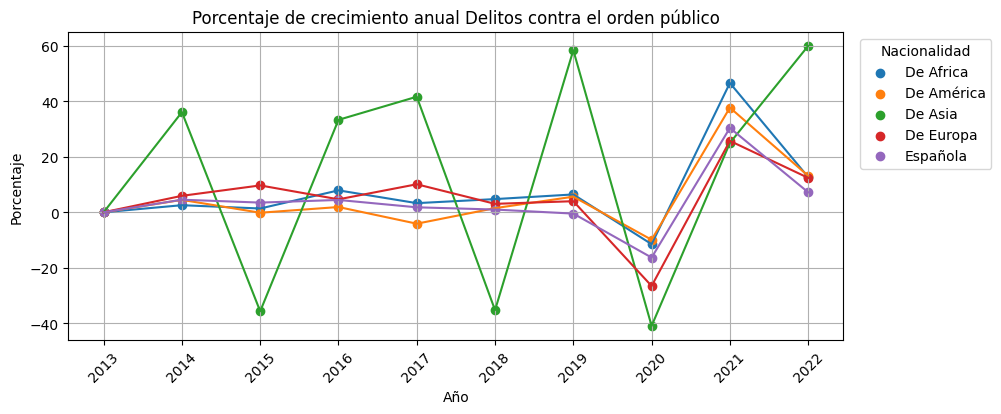

In [41]:
plt.figure(figsize=(10,4))

for nacionalidad in nacionalidades:
    subset = orden_publico[orden_publico["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["porcentaje_crecimiento"], marker="o", label= nacionalidad)
    plt.plot(subset["periodo"], subset["porcentaje_crecimiento"])
    
plt.xticks(range(2013,2023), rotation= 45)

plt.xlabel("Año")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de crecimiento anual Delitos contra el orden público")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

<h2 style="color: #327a81;">Type: Against Collective Security</h2>

- Find an error in one "total" value that shows a weird result on the time evolution plot. So let's correct it.

In [42]:
print(seguridad_colectiva.loc[113, "total"])
print(seguridad_colectiva.loc[114, "total"])
print(seguridad_colectiva.loc[115, "total"])

76085
76
77105


-  As we can see it above, the value on index 114 should be 76k aprox. It will be better if we replace this value with the average of the other two

In [43]:
value_113 = seguridad_colectiva.loc[113, "total"]
value_115 = seguridad_colectiva.loc[115, "total"]
value_114 = (value_113 + value_115) // 2

seguridad_colectiva.loc[114, "total"] = value_114

<h3 style="color: #60b671;">Decade Numbers and Percetage</h3>

In [44]:
seguridad_colectiva_general = seguridad_colectiva.groupby("nacionalidad")["total"].sum().sort_values(ascending=False).reset_index()

In [45]:
seguridad_colectiva_general

,nacionalidad,total
0,Española,790458
1,De América,105449
2,De Europa,82864
3,De Africa,53304
4,De Asia,7136


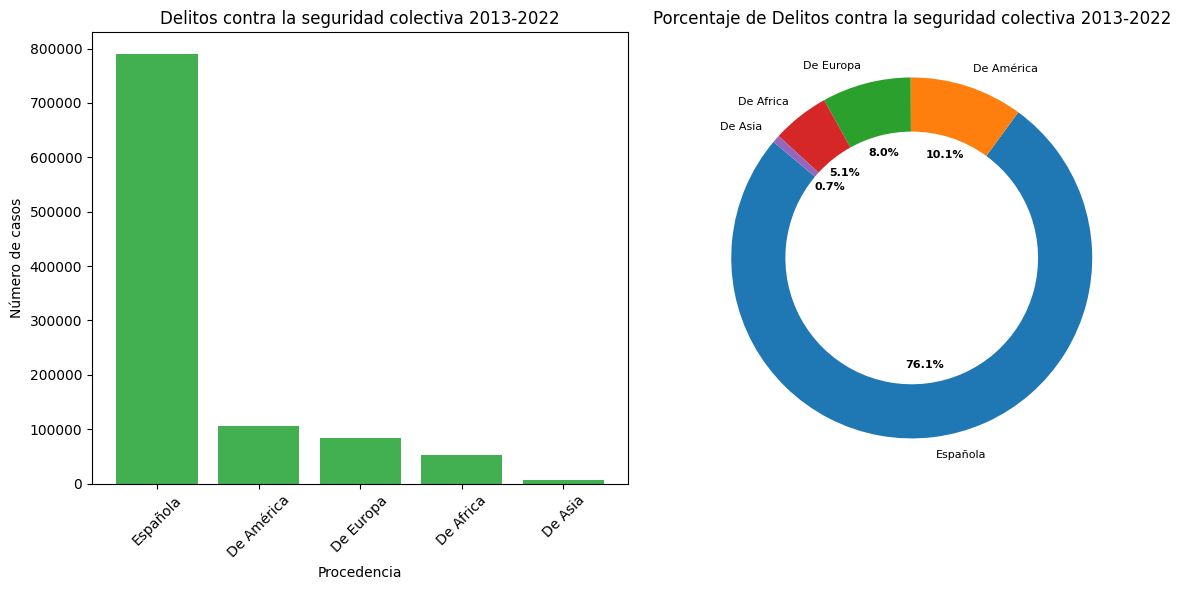

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(seguridad_colectiva_general["nacionalidad"], seguridad_colectiva_general["total"], color="#42af50")
axes[0].set_xlabel("Procedencia")
axes[0].set_ylabel("Número de casos")
axes[0].set_title("Delitos contra la seguridad colectiva 2013-2022")
axes[0].tick_params(axis='x', rotation=45)

seguridad_colectiva_general["porcentaje"] = round(seguridad_colectiva_general["total"] / seguridad_colectiva_general["total"].sum() * 100, 2)

wedges, texts, autotexts = axes[1].pie(seguridad_colectiva_general["porcentaje"], labels=seguridad_colectiva_general["nacionalidad"], 
                                       autopct="%1.1f%%", startangle=140, wedgeprops=dict(width=0.3))
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)
axes[1].set_title("Porcentaje de Delitos contra la seguridad colectiva 2013-2022")

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Evolution in the last 10 years</h3>

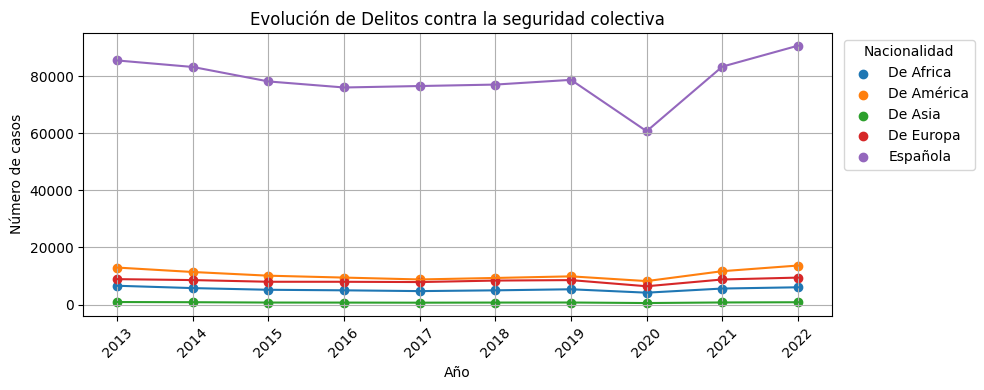

In [47]:
plt.figure(figsize=(10,4))

for i, nacionalidad in enumerate(nacionalidades):
    subset = seguridad_colectiva[seguridad_colectiva["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["total"], label= nacionalidad)
    plt.plot(subset["periodo"], subset["total"])
    
plt.xticks(range(2013,2023), rotation= 45)
    
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.title("Evolución de Delitos contra la seguridad colectiva")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Percentage of crime growth by year</h3>

In [48]:
seguridad_colectiva["porcentaje_crecimiento"] = round(seguridad_colectiva.groupby("nacionalidad")["total"].pct_change()*100,2)
seguridad_colectiva["porcentaje_crecimiento"].fillna(0, inplace=True)

In [49]:
# Calculate average percentage growth in the last decade

seguridad_colectiva.groupby("nacionalidad")["porcentaje_crecimiento"].mean()

nacionalidad
De Africa     0.173
De América    1.755
De Asia       0.383
De Europa     1.609
Española      1.522
Name: porcentaje_crecimiento, dtype: float64

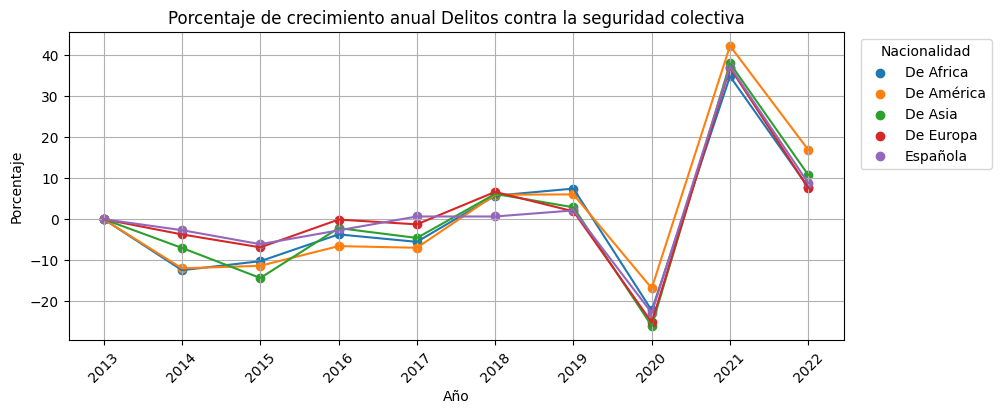

In [51]:
plt.figure(figsize=(10,4))

for nacionalidad in nacionalidades:
    subset = seguridad_colectiva[seguridad_colectiva["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["porcentaje_crecimiento"], marker="o", label= nacionalidad)
    plt.plot(subset["periodo"], subset["porcentaje_crecimiento"])
    
plt.xticks(range(2013,2023), rotation= 45)

plt.xlabel("Año")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de crecimiento anual Delitos contra la seguridad colectiva")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

<h2 style="color: #327a81;">Type: Theft</h2>

<h3 style="color: #60b671;">Decade Numbers and Percetage</h3>

In [52]:
hurtos_general = hurtos.groupby("nacionalidad")["total"].sum().sort_values(ascending=False).reset_index()

In [53]:
hurtos_general

,nacionalidad,total
0,Española,312769
1,De Europa,73221
2,De Africa,40929
3,De América,36139
4,De Asia,3897


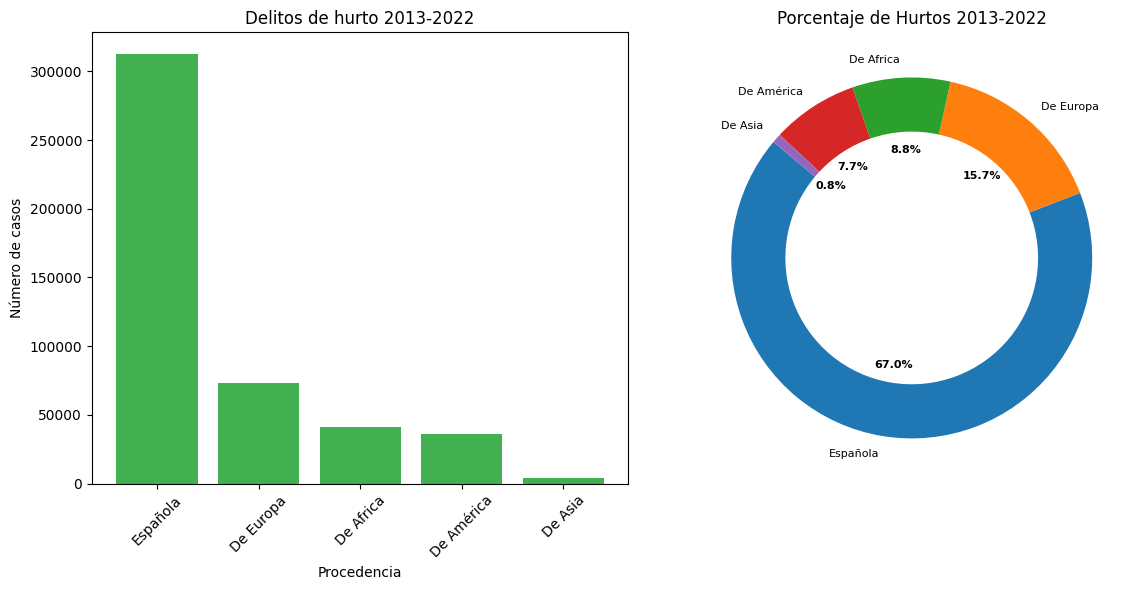

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(hurtos_general["nacionalidad"], hurtos_general["total"], color="#42af50")
axes[0].set_xlabel("Procedencia")
axes[0].set_ylabel("Número de casos")
axes[0].set_title("Delitos de hurto 2013-2022")
axes[0].tick_params(axis='x', rotation=45)

hurtos_general["porcentaje"] = round(hurtos_general["total"] / hurtos_general["total"].sum() * 100, 2)

wedges, texts, autotexts = axes[1].pie(hurtos_general["porcentaje"], labels=hurtos_general["nacionalidad"], 
                                       autopct="%1.1f%%", startangle=140, wedgeprops=dict(width=0.3))
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)
axes[1].set_title("Porcentaje de Hurtos 2013-2022")

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Evolution in the last 10 years</h3>

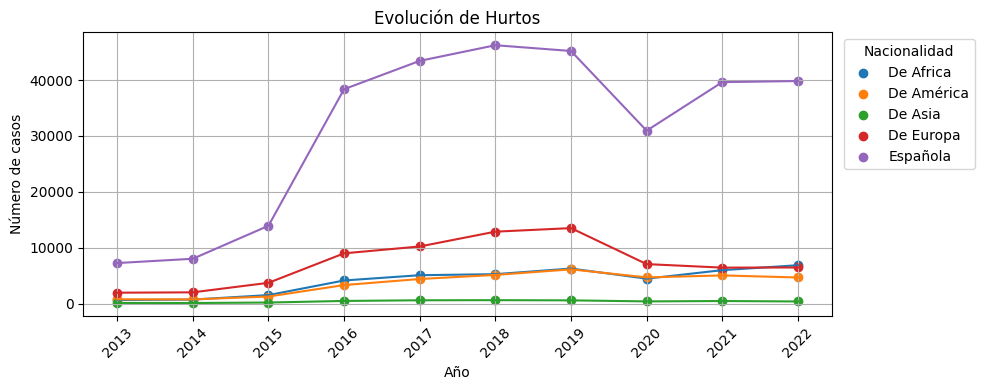

In [56]:
plt.figure(figsize=(10,4))

for i, nacionalidad in enumerate(nacionalidades):
    subset = hurtos[hurtos["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["total"], label= nacionalidad)
    plt.plot(subset["periodo"], subset["total"])
    
plt.xticks(range(2013,2023), rotation= 45)
    
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.title("Evolución de Hurtos")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Percentage of crime growth by year</h3>

In [57]:
hurtos["porcentaje_crecimiento"] = round(hurtos.groupby("nacionalidad")["total"].pct_change()*100,2)
hurtos["porcentaje_crecimiento"].fillna(0, inplace=True)

In [58]:
# Calculate average percentage growth in the last decade

hurtos.groupby("nacionalidad")["porcentaje_crecimiento"].mean()

nacionalidad
De Africa     36.162
De América    27.446
De Asia       21.246
De Europa     21.816
Española      27.415
Name: porcentaje_crecimiento, dtype: float64

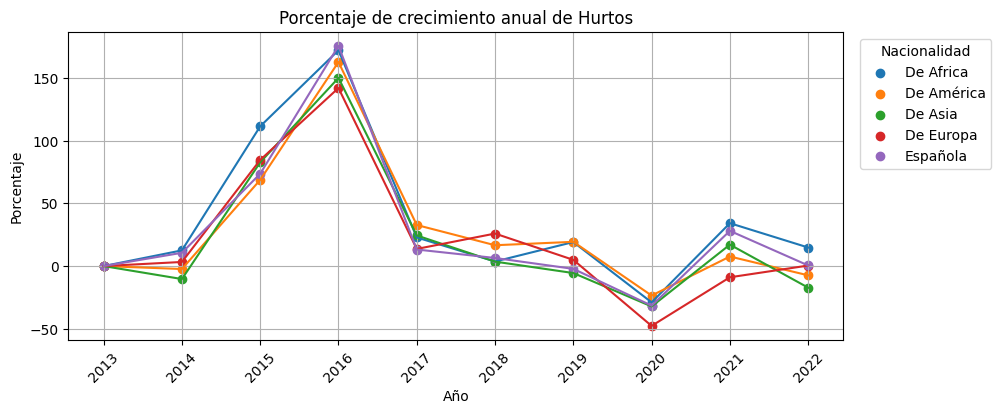

In [60]:
plt.figure(figsize=(10,4))

for nacionalidad in nacionalidades:
    subset = hurtos[hurtos["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["porcentaje_crecimiento"], marker="o", label= nacionalidad)
    plt.plot(subset["periodo"], subset["porcentaje_crecimiento"])
    
plt.xticks(range(2013,2023), rotation= 45)

plt.xlabel("Año")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de crecimiento anual de Hurtos")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

<h2 style="color: #327a81;">Type: Robbery</h2>

<h3 style="color: #60b671;">Decade Numbers and Percetage</h3>

In [63]:
robos_general = robos.groupby("nacionalidad")["total"].sum().sort_values(ascending=False).reset_index()

In [64]:
robos_general

,nacionalidad,total
0,Española,193977
1,De Africa,29677
2,De Europa,25060
3,De América,11159
4,De Asia,1017


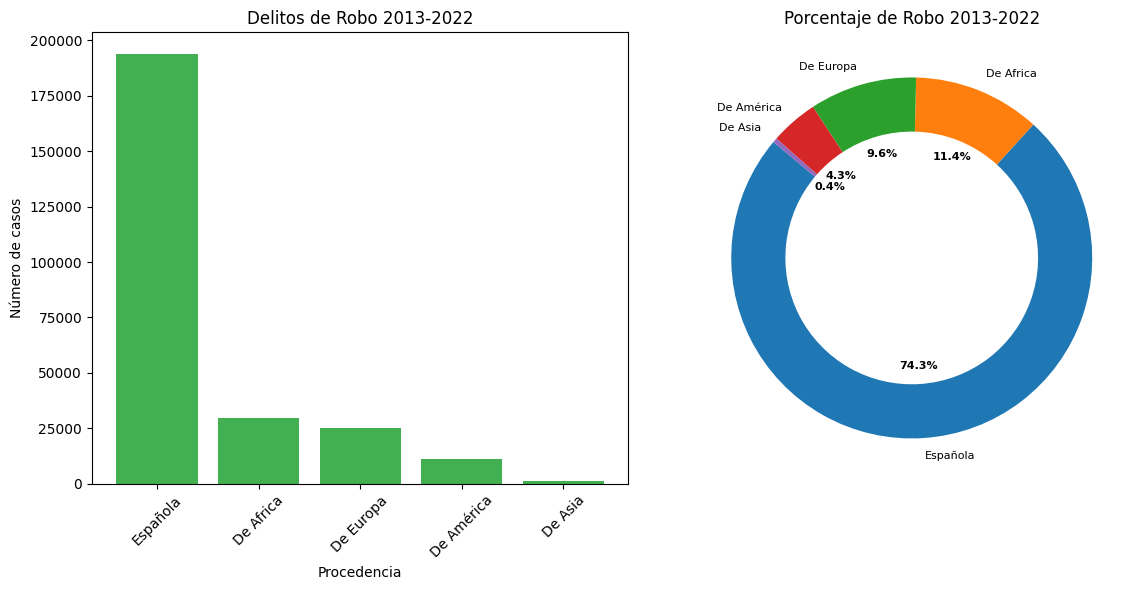

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(robos_general["nacionalidad"], robos_general["total"], color="#42af50")
axes[0].set_xlabel("Procedencia")
axes[0].set_ylabel("Número de casos")
axes[0].set_title("Delitos de Robo 2013-2022")
axes[0].tick_params(axis='x', rotation=45)

robos_general["porcentaje"] = round(robos_general["total"] / robos_general["total"].sum() * 100, 2)

wedges, texts, autotexts = axes[1].pie(robos_general["porcentaje"], labels=robos_general["nacionalidad"], 
                                       autopct="%1.1f%%", startangle=140, wedgeprops=dict(width=0.3))
plt.setp(autotexts, size=8, weight="bold")
plt.setp(texts, size=8)
axes[1].set_title("Porcentaje de Robo 2013-2022")

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Evolution in the last 10 years</h3>

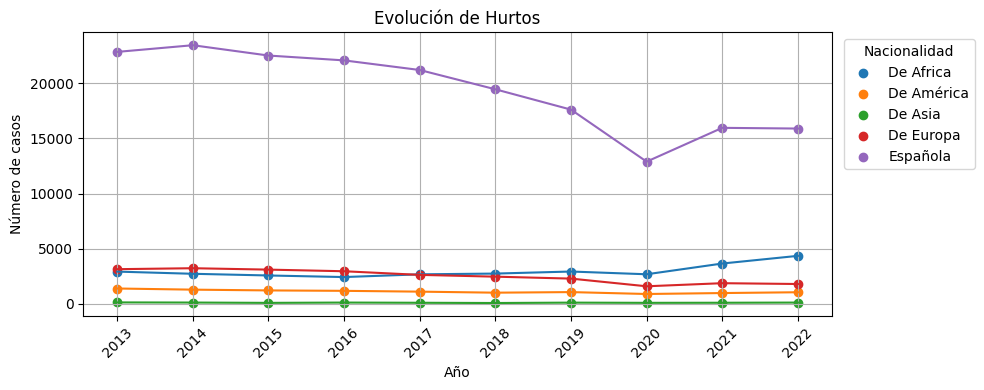

In [66]:
plt.figure(figsize=(10,4))

for i, nacionalidad in enumerate(nacionalidades):
    subset = robos[robos["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["total"], label= nacionalidad)
    plt.plot(subset["periodo"], subset["total"])
    
plt.xticks(range(2013,2023), rotation= 45)
    
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.title("Evolución de Robo")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

plt.tight_layout()
plt.show()

<h3 style="color: #60b671;">Percentage of crime growth by year</h3>

In [69]:
robos["porcentaje_crecimiento"] = round(robos.groupby("nacionalidad")["total"].pct_change()*100,2)
robos["porcentaje_crecimiento"].fillna(0, inplace=True)

In [71]:
# Calculate average percentage growth in the last decade

robos.groupby("nacionalidad")["porcentaje_crecimiento"].mean()

nacionalidad
De Africa     4.846
De América   -2.469
De Asia       1.390
De Europa    -4.716
Española     -2.839
Name: porcentaje_crecimiento, dtype: float64

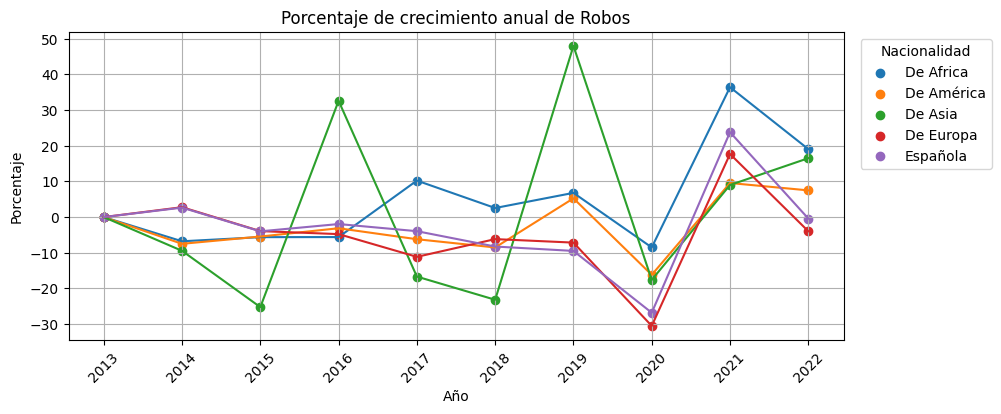

In [72]:
plt.figure(figsize=(10,4))

for nacionalidad in nacionalidades:
    subset = robos[robos["nacionalidad"] == nacionalidad]
    plt.scatter(subset["periodo"], subset["porcentaje_crecimiento"], marker="o", label= nacionalidad)
    plt.plot(subset["periodo"], subset["porcentaje_crecimiento"])
    
plt.xticks(range(2013,2023), rotation= 45)

plt.xlabel("Año")
plt.ylabel("Porcentaje")
plt.title("Porcentaje de crecimiento anual de Robos")
plt.legend(title="Nacionalidad", bbox_to_anchor=(1.2,1), loc="upper right")
plt.grid(True)

<h2 style="color: #327a81;">Type: Injuries</h2>

In [74]:
df

,tipo_delito,nacionalidad,periodo,total
0,Contra el orden público,De Africa,2013,1218
1,Contra el orden público,De Africa,2014,1249
2,Contra el orden público,De Africa,2015,1266
3,Contra el orden público,De Africa,2016,1366
4,Contra el orden público,De Africa,2017,1411
...,...,...,...,...
415,Robos,Española,2018,19462
416,Robos,Española,2019,17617
417,Robos,Española,2020,12898
418,Robos,Española,2021,15965
